In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/automni/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# PPO_EKF_25

|||
|-|-|
| randomize_offset | false |
| horizon | 32768 |
| reward_fn | rw_distance_normalized |
| map | Town01 |

In [6]:
# time, frame1_x, frame1_y, frame2_x, frame2_y, ...
trajectories_25 = pd.read_csv('data/PPO_EKF_25/full/trajectories.csv')
trajectories_25.sort_values(by='time', inplace=True)
trajectories_25['time'] -= trajectories_25['time'].min()
trajectories_25.dropna(inplace=True)
print(trajectories_25.shape)
trajectories_25.head()

(2368, 18)


,time,EGO_1/IMU_x,EGO_1/IMU_y,base_link_x,base_link_y,model_frame_x,model_frame_y,EKF_x,EKF_y,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,yaw,speed,steering_angle
47,2.352034,201.122864,-59.490242,201.009806,-59.483623,193.730489,-79.946239,200.913161,59.483689,-0.483945,0.080253,9.813789,0.000085,-0.001391,-0.001289,0.042218,6.266351,0.006152
48,2.399525,201.425522,-59.490036,201.360567,-59.483414,196.215928,-79.112393,201.215481,59.483511,0.638268,-0.000528,9.853785,0.000087,-0.005893,-0.000418,0.039285,6.391338,0.005864
49,2.446848,201.732666,-59.489826,201.737664,-59.483155,193.242641,-79.699916,201.634323,59.483221,0.641106,0.019504,9.858562,0.000016,-0.004859,-0.000362,0.037591,6.496689,0.011576
50,2.497987,202.072632,-59.489609,201.986423,-59.482986,198.264258,-77.095193,201.737664,59.483155,4.323206,0.036865,9.791489,-0.000013,-0.006947,-0.000436,0.037253,6.637322,0.014791
51,2.545275,202.395050,-59.489399,202.238007,-59.482826,197.746848,-76.782887,201.986423,59.482986,4.485571,0.036817,9.791759,0.000005,-0.006466,-0.000381,0.036390,6.821160,0.010400


In [8]:
# Separate frames
def split_frames(filename):
    df = pd.read_csv(filename)
    df.sort_values(by='time', inplace=True)
    df['time'] -= df['time'].min()
    df.dropna(inplace=True)

    gt = df[['time', 'EGO_1/IMU_x', 'EGO_1/IMU_y']].rename(columns={'EGO_1/IMU_x': 'x', 'EGO_1/IMU_y': 'y'})
    gt['y'] = -gt['y']

    EKF = df[['time', 'base_link_x', 'base_link_y']].rename(columns={'base_link_x': 'x', 'base_link_y': 'y'})
    EKF['y'] = -EKF['y']
    EKF['error_x'] = EKF['x'] - gt['x']
    EKF['error_y'] = EKF['y'] - gt['y']
    EKF['error'] = np.sqrt(EKF['error_x']**2 + EKF['error_y']**2)

    model = df[['time', 'model_frame_x', 'model_frame_y']].rename(columns={'model_frame_x': 'x', 'model_frame_y': 'y'})
    model['y'] = -model['y']
    model['error_x'] = model['x'] - gt['x']
    model['error_y'] = model['y'] - gt['y']
    model['error'] = np.sqrt(model['error_x']**2 + model['error_y']**2)

    return gt, EKF, model

gt_25, EKF_25, model_25 = split_frames('data/PPO_EKF_25/full/trajectories.csv')
gt_25.head(), EKF_25.head(), model_25.head()

(        time           x          y
 47  2.352034  201.122864  59.490242
 48  2.399525  201.425522  59.490036
 49  2.446848  201.732666  59.489826
 50  2.497987  202.072632  59.489609
 51  2.545275  202.395050  59.489399,
         time           x          y   error_x   error_y     error
 47  2.352034  201.009806  59.483623 -0.113058 -0.006619  0.113251
 48  2.399525  201.360567  59.483414 -0.064955 -0.006622  0.065292
 49  2.446848  201.737664  59.483155  0.004998 -0.006671  0.008336
 50  2.497987  201.986423  59.482986 -0.086209 -0.006622  0.086463
 51  2.545275  202.238007  59.482826 -0.157043 -0.006573  0.157180,
         time           x          y   error_x    error_y      error
 47  2.352034  193.730489  79.946239 -7.392375  20.455997  21.750748
 48  2.399525  196.215928  79.112393 -5.209594  19.622357  20.302137
 49  2.446848  193.242641  79.699916 -8.490025  20.210089  21.920954
 50  2.497987  198.264258  77.095193 -3.808374  17.605584  18.012781
 51  2.545275  197.746848  76

# Figures

## Trajectory excerpt

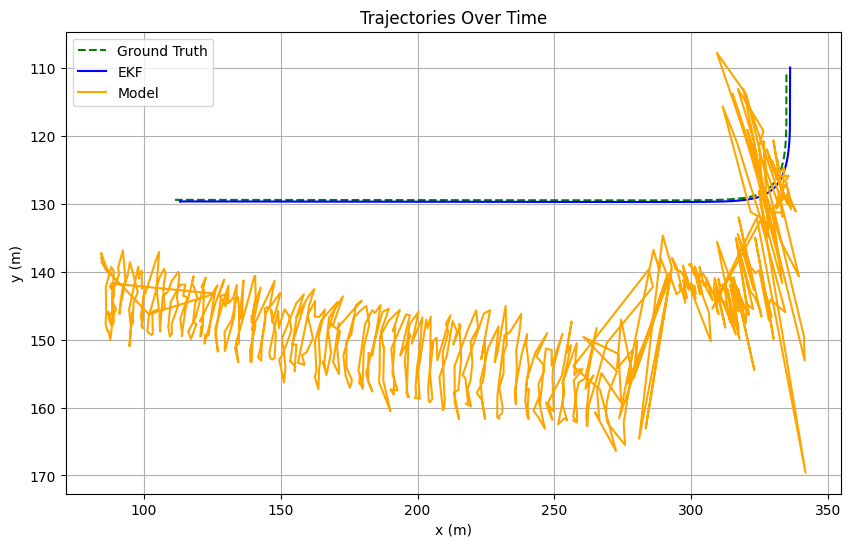

In [21]:
# Plot trajectories over specified horizon
# t0 = 140
# t1 = 160
t0 = 70
t1 = 150
mask = (gt_25['time'] >= t0) & (gt_25['time'] <= t1)

plt.figure(figsize=(10, 6))
plt.plot(gt_25['x'][mask], gt_25['y'][mask], label='Ground Truth', color='green', linestyle='--')
plt.plot(EKF_25['x'][mask], EKF_25['y'][mask], label='EKF', color='blue')
plt.plot(model_25['x'][mask], model_25['y'][mask], label='Model', color='orange')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.title('Trajectories Over Time')
plt.legend()
plt.grid()
plt.show()

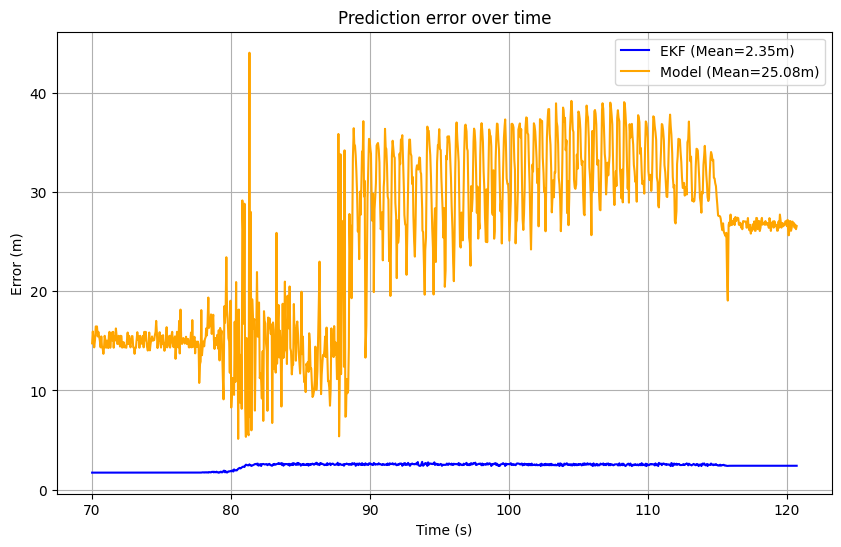

In [22]:
# Plot errors over time
plt.figure(figsize=(10, 6))
t = gt_25['time'][mask]
error_EKF = EKF_25['error'][mask]
error_model = model_25['error'][mask]
plt.plot(t, error_EKF, label=f"EKF (Mean={error_EKF.mean():.2f}m)", color='blue')
plt.plot(t, error_model, label=f"Model (Mean={error_model.mean():.2f}m)", color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Error (m)')
plt.title('Prediction error over time')
plt.legend()
plt.grid()
plt.show()

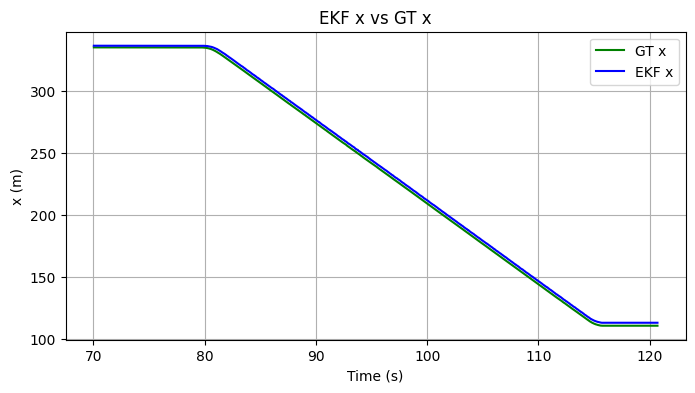

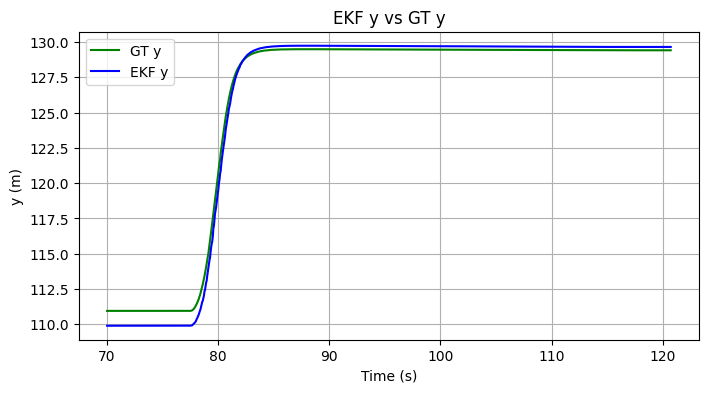

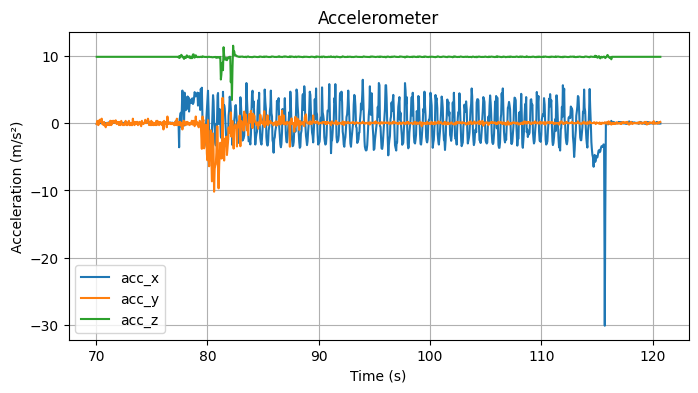

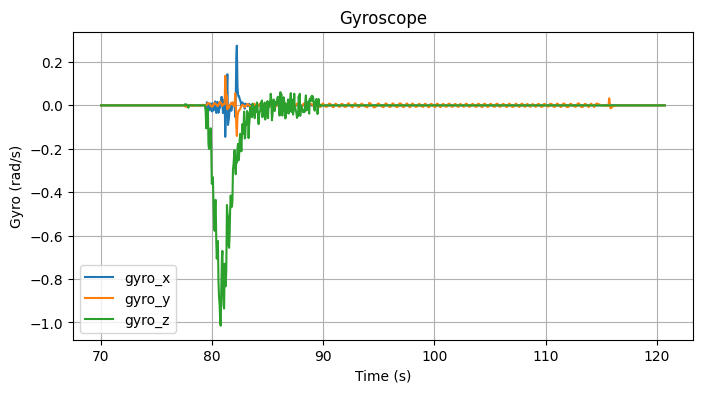

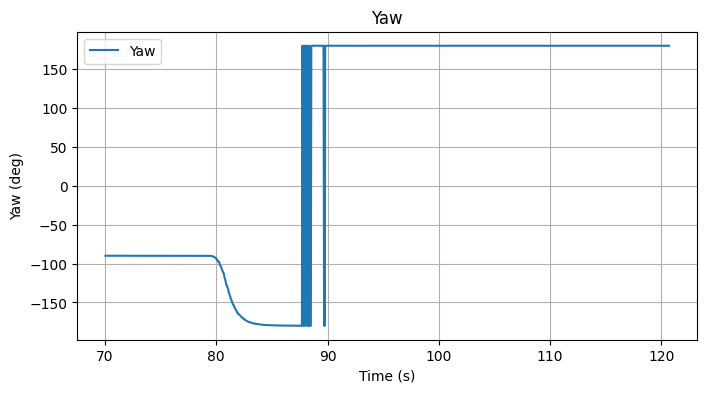

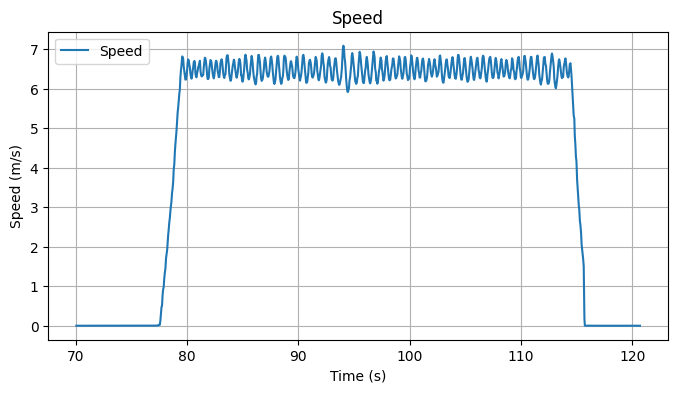

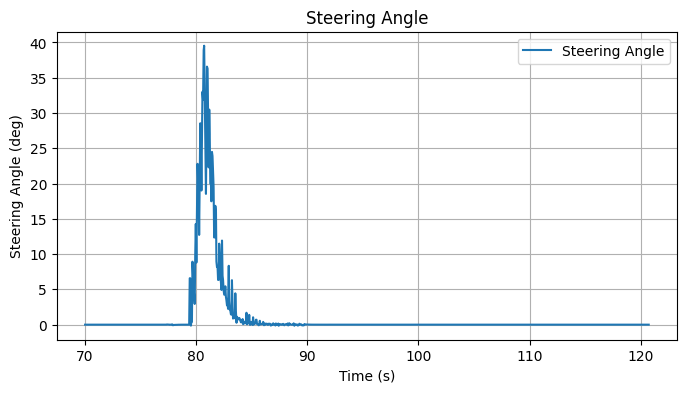

In [23]:
# Plot 1: EKF_x vs GT_x
plt.figure(figsize=(8, 4))
plt.plot(gt_25['time'][mask], gt_25['x'][mask], label='GT x', color='green')
plt.plot(EKF_25['time'][mask], EKF_25['x'][mask], label='EKF x', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('x (m)')
plt.title('EKF x vs GT x')
plt.legend()
plt.grid()
plt.show()

# Plot 2: EKF_y vs GT_y
plt.figure(figsize=(8, 4))
plt.plot(gt_25['time'][mask], gt_25['y'][mask], label='GT y', color='green')
plt.plot(EKF_25['time'][mask], EKF_25['y'][mask], label='EKF y', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.title('EKF y vs GT y')
plt.legend()
plt.grid()
plt.show()

# Plot 3: acc_{x,y,z}
plt.figure(figsize=(8, 4))
plt.plot(trajectories_25['time'][mask], trajectories_25['acc_x'][mask], label='acc_x')
plt.plot(trajectories_25['time'][mask], trajectories_25['acc_y'][mask], label='acc_y')
plt.plot(trajectories_25['time'][mask], trajectories_25['acc_z'][mask], label='acc_z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.title('Accelerometer')
plt.legend()
plt.grid()
plt.show()

# Plot 4: gyro_{x,y,z}
plt.figure(figsize=(8, 4))
plt.plot(trajectories_25['time'][mask], trajectories_25['gyro_x'][mask], label='gyro_x')
plt.plot(trajectories_25['time'][mask], trajectories_25['gyro_y'][mask], label='gyro_y')
plt.plot(trajectories_25['time'][mask], trajectories_25['gyro_z'][mask], label='gyro_z')
plt.xlabel('Time (s)')
plt.ylabel('Gyro (rad/s)')
plt.title('Gyroscope')
plt.legend()
plt.grid()
plt.show()

# Plot 5: Yaw
plt.figure(figsize=(8, 4))
plt.plot(trajectories_25['time'][mask], trajectories_25['yaw'][mask], label='Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Yaw (deg)')
plt.title('Yaw')
plt.legend()
plt.grid()
plt.show()

# Plot 6: Speed
plt.figure(figsize=(8, 4))
plt.plot(trajectories_25['time'][mask], trajectories_25['speed'][mask], label='Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed')
plt.legend()
plt.grid()
plt.show()

# Plot 7: Steering angle
plt.figure(figsize=(8, 4))
plt.plot(trajectories_25['time'][mask], trajectories_25['steering_angle'][mask], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (deg)')
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()

## Heatmaps

In [113]:
# Plot a heatmap of mean model error, with empty bins shown as white
def heatmap(x, y, errors, bins, title):
    sum_errors, xedges, yedges = np.histogram2d(
        x, y,
        bins=bins,
        weights=errors
    )
    counts, _, _ = np.histogram2d(
        x, y,
        bins=[xedges, yedges]
    )
    mean_errors = np.divide(sum_errors, counts, out=np.zeros_like(sum_errors), where=counts > 0)
    mean_errors[counts == 0] = np.nan

    cmap = plt.get_cmap('plasma').copy()
    cmap.set_bad('white')

    plt.figure(figsize=(10, 8))
    plt.imshow(
        mean_errors.T,
        origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect='auto',
        cmap=cmap
    )
    plt.colorbar(label='Mean Error (m)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.grid()
    plt.show()


EKF:
	Mean: 1.466 m
	Std: 1.617 m
	Max: 23.462 m
Model:
	Mean: 19.344 m
	Std: 19.913 m
	Max: 347.687 m


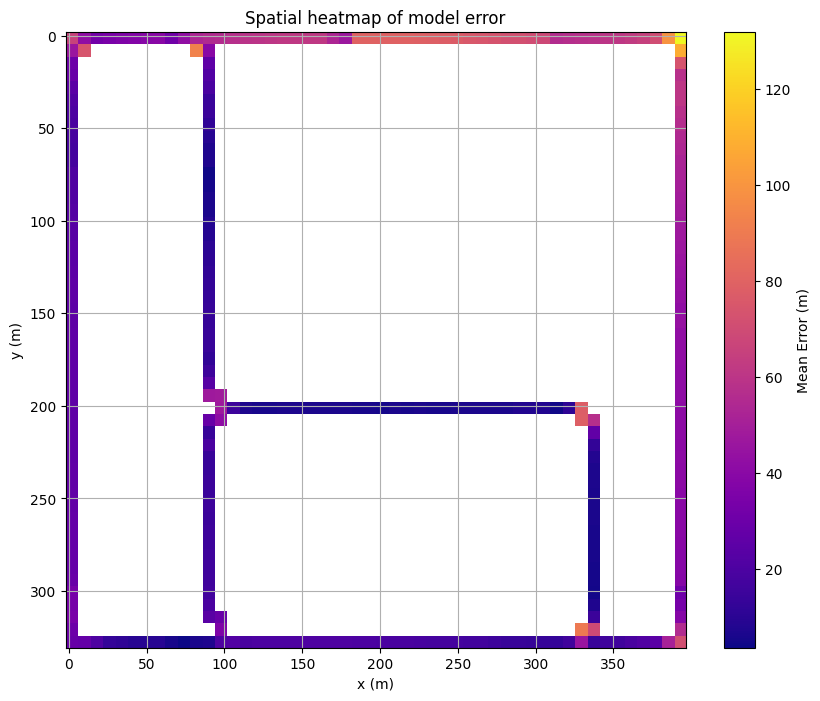

In [ ]:
files = [
    'data/PPO_EKF_25/town01_1.csv',
    'data/PPO_EKF_25/town01_2.csv',
    'data/PPO_EKF_25/town01_3.csv'
]
gt = []
EKF = []
model = []
for file in files:
    g, e, m = split_frames(file)
    gt.append(g)
    EKF.append(e)
    model.append(m)

# Concatenate the dataframes for comparison
gt_25_combined = pd.concat(gt, ignore_index=True)
EKF_25_combined = pd.concat(EKF, ignore_index=True)
model_25_combined = pd.concat(model, ignore_index=True)

print(f"EKF:\n\tMean: {EKF_25_combined['error'].mean():.3f} m\n\tStd: {EKF_25_combined['error'].std():.3f} m\n\tMax: {EKF_25_combined['error'].max():.3f} m")
print(f"Model:\n\tMean: {model_25_combined['error'].mean():.3f} m\n\tStd: {model_25_combined['error'].std():.3f} m\n\tMax: {model_25_combined['error'].max():.3f} m")
heatmap(gt_25_combined['x'], gt_25_combined['y'], model_25_combined['error'], 50, title="Spatial heatmap of model error")

EKF:
	Mean: 1.643 m
	Std: 0.855 m
	Max: 7.405 m
Model:
	Mean: 19.678 m
	Std: 15.207 m
	Max: 400.431 m


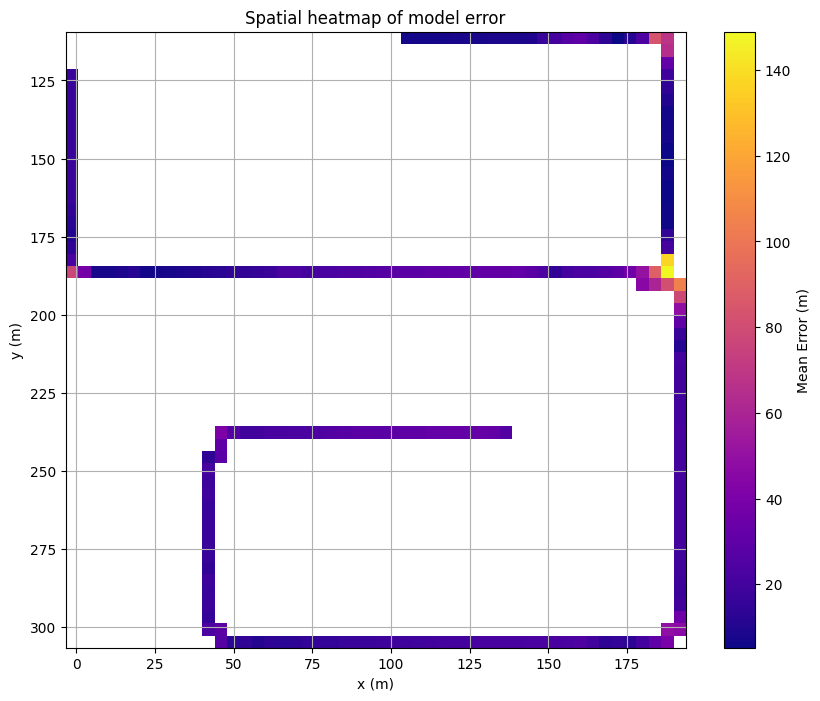

In [116]:
files = [
    'data/PPO_EKF_25/town02_1.csv',
    'data/PPO_EKF_25/town02_2.csv',
]
gt = []
EKF = []
model = []
for file in files:
    g, e, m = split_frames(file)
    gt.append(g)
    EKF.append(e)
    model.append(m)

# Concatenate the dataframes for comparison
gt_25_combined = pd.concat(gt, ignore_index=True)
EKF_25_combined = pd.concat(EKF, ignore_index=True)
model_25_combined = pd.concat(model, ignore_index=True)

print(f"EKF:\n\tMean: {EKF_25_combined['error'].mean():.3f} m\n\tStd: {EKF_25_combined['error'].std():.3f} m\n\tMax: {EKF_25_combined['error'].max():.3f} m")
print(f"Model:\n\tMean: {model_25_combined['error'].mean():.3f} m\n\tStd: {model_25_combined['error'].std():.3f} m\n\tMax: {model_25_combined['error'].max():.3f} m")
heatmap(gt_25_combined['x'], gt_25_combined['y'], model_25_combined['error'], 50, title="Spatial heatmap of model error")